In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import hashlib
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt

Load OMI datasets (https://www.agenziaentrate.gov.it/portale/it/web/guest/schede/fabbricatiterreni/omi/forniture-dati-omi)

In [2]:
folder = "C:/Users/HP/Desktop/Traineeship/data/OMI_estimates/values"

# Grab all CSV files
all_files = glob.glob(os.path.join(folder, "*.csv"))

Read .csv files and merge them in long_df

In [3]:
out_dir = "cleaned_parquet"
os.makedirs(out_dir, exist_ok=True)

dfs = []

for i,f in enumerate(all_files):
    """
    Read every dataset in the folder as input.

    Extract year and semester from the file name.

    Delete useless columns.

    Create mun_key.

    Return datasets with updated istat codes. 
    """
    # Extract filename without extension
    filename = os.path.splitext(os.path.basename(f))[0]
    
    # Extract semester code
    parts = filename.split("_")
    semester_code = parts[-2]  # second to last part
    year = semester_code[:4]
    sem = semester_code[4]
    semester = f"{year}_S{sem}"
    
    # Read CSV, skip first title line
    df = pd.read_csv(f, sep=';', skiprows=1)
    
    # Strip whitespace and remove BOM from column names
    df.columns = df.columns.str.strip().str.replace('\ufeff','')

    # Add semester column
    df['semester'] = semester

    # Delete useless columns
    columns = ['Comune_cat','Comune_amm','Sez','Cod_Tip','Stato_prev', 'Sup_NL_compr', 'Sup_NL_loc']

    df = df.drop(columns=columns)
    
    # Convert numeric columns to numeric type
    numeric_cols = ['Compr_min', 'Compr_max', 'Loc_min', 'Loc_max']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

    # Normalize municipality and region names
    df['mun_name_norm'] = df['Comune_descrizione'].apply(normalize_name).astype('object')

    df['reg_name_norm'] = df['Regione'].apply(normalize_name).astype('object')

    # Create 'mun_key'
    df['mun_key'] = df['mun_name_norm'] + '_' + df['reg_name_norm'] 
    
    # Convert object columns to category
    for col in df.select_dtypes(include = 'object').columns:
        df[col] = df[col].astype('category')

    # keep the last 6 digits of mun_istat
    df['Comune_ISTAT'] = df['Comune_ISTAT'].astype('Int64').astype('str').str[-6:]


    dfs.append(df)

In [4]:
long_df = pd.concat(dfs, ignore_index=True)

In [5]:
long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7201300 entries, 0 to 7201299
Data columns (total 19 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Area_territoriale   category
 1   Regione             category
 2   Prov                category
 3   Comune_ISTAT        object  
 4   Comune_descrizione  object  
 5   Fascia              category
 6   Zona                object  
 7   LinkZona            object  
 8   Descr_Tipologia     object  
 9   Stato               category
 10  Compr_min           float64 
 11  Compr_max           float64 
 12  Loc_min             float64 
 13  Loc_max             float64 
 14  Unnamed: 21         float64 
 15  semester            object  
 16  mun_name_norm       object  
 17  reg_name_norm       category
 18  mun_key             object  
dtypes: category(6), float64(5), object(8)
memory usage: 755.5+ MB


Translating

In [6]:
column_renames = {
    "Area_territoriale": "location",
    "Regione": "region",
    "Prov": "prov",
    "Comune_descrizione": "mun_name",
    "Comune_ISTAT" : "mun_istat",
    "Fascia": "sector",
    "Zona": "zone",
    "LinkZona": "zone_link",
    "Descr_Tipologia": "type",
    "Stato": "condition",
    "Compr_min": "buy_min",
    "Compr_max": "buy_max",
    "Loc_min": "lease_min",
    "Loc_max": "lease_max"
}

long_df = long_df.rename(columns=column_renames)

# Apply value mappings
long_df["location"] = long_df["location"].replace({
    "NORD-OVEST": "NW",
    "NORD-EST": "NE",
    "CENTRO": "C",
    "ISOLE": "I",
    "SUD": "S"
})

long_df["type"] = long_df["type"].replace({
    "Abitazioni civili": "residential housing",
    "Box": "garage",
    "Ville e Villini": "independent houses and villas",
    "Negozi": "shops",
    "Abitazioni di tipo economico": "lowcost housing",
    "Magazzini": "warehouses",
    "Uffici": "offices",
    "Laboratori": "laboratories",
    "Capannoni tipici": "typical industrial buildings",
    "Capannoni industriali": "industrial buildings",
    "Autorimesse": "garages",
    "Posti auto scoperti": "uncovered parking spaces",
    "Posti auto coperti": "covered parking spaces",
    "Centri commerciali": "shopping centers",
    "Uffici strutturati": "structured offices",
    "Abitazioni tipiche dei luoghi": "typical local housing",
    "Abitazioni signorili": "luxury housing",
    "Pensioni e assimilati": "guesthouses and similar",
    "Fabbricati e locali per esercizi sportivi": "sports facilities"
})

long_df["condition"] = long_df["condition"].replace({
    "NORMALE": "normal",
    "OTTIMO": "excellent",
    "SCADENTE": "poor"
})

long_df.info()

C:\Users\HP\AppData\Local\Temp\ipykernel_9476\275081353.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  long_df["location"] = long_df["location"].replace({


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7201300 entries, 0 to 7201299
Data columns (total 19 columns):
 #   Column         Dtype   
---  ------         -----   
 0   location       category
 1   region         category
 2   prov           category
 3   mun_istat      object  
 4   mun_name       object  
 5   sector         category
 6   zone           object  
 7   zone_link      object  
 8   type           object  
 9   condition      category
 10  buy_min        float64 
 11  buy_max        float64 
 12  lease_min      float64 
 13  lease_max      float64 
 14  Unnamed: 21    float64 
 15  semester       object  
 16  mun_name_norm  object  
 17  reg_name_norm  category
 18  mun_key        object  
dtypes: category(6), float64(5), object(8)
memory usage: 755.5+ MB


C:\Users\HP\AppData\Local\Temp\ipykernel_9476\275081353.py:51: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  long_df["condition"] = long_df["condition"].replace({


Deleting useless columns

In [7]:
columns = ['reg_name_norm','Unnamed: 21']

long_df = long_df.drop(columns=columns)

Checking Istat codes

In [8]:
# Check if each ISTAT code maps to more than one mun_key
desc_check = long_df.groupby('mun_istat')['mun_key'].nunique().reset_index()
desc_inconsistent = desc_check[desc_check['mun_key'] > 1]

print("Number of ISTAT codes with multiple mun_keys:", len(desc_inconsistent))

# Number of unique Istat codes
print('Number of unique Istat codes:',long_df['mun_istat'].nunique())

Number of ISTAT codes with multiple mun_keys: 14
Number of unique Istat codes: 8229


In [9]:
# Count the number of duplicate listings
duplicates = long_df.value_counts(subset=['mun_istat', 'zone', 'sector', 'condition', 'type', 'semester'])

duplicates = duplicates[duplicates > 1]

print("Number of duplicate listings for the same semester:", duplicates.sum())

Number of duplicate listings for the same semester: 1669


In [10]:
# Delete duplicate listings for the same semester - keep the first occurrence
long_df = long_df.drop_duplicates(subset=['mun_istat', 'zone', 'sector', 'condition', 'type', 'semester'], keep='first')

Pre-check on missing values

In [11]:
# Check for missing values
missing_values = long_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 location              0
region                0
prov             149328
mun_istat             0
mun_name              0
sector                0
zone                  0
zone_link             0
type                  0
condition         96241
buy_min            1540
buy_max            1540
lease_min        516896
lease_max        516896
semester              0
mun_name_norm         0
mun_key               0
dtype: int64


Imputing missing 'prov' values

In [12]:
# Check in which region there are more missing 'prov' values
missing_province = long_df[long_df['prov'].isnull()]['region'].value_counts()
print("Missing 'prov' values by region:\n", missing_province)

Missing 'prov' values by region:
 region
CAMPANIA                         149328
ABRUZZO                               0
BASILICATA                            0
CALABRIA                              0
EMILIA-ROMAGNA                        0
FRIULI-VENEZIA GIULIA                 0
LAZIO                                 0
LIGURIA                               0
LOMBARDIA                             0
MARCHE                                0
MOLISE                                0
PIEMONTE                              0
PUGLIA                                0
SARDEGNA                              0
SICILIA                               0
TOSCANA                               0
TRENTINO-ALTO ADIGE                   0
UMBRIA                                0
VALLE D'AOSTA/VALLE`E D'AOSTE         0
VENETO                                0
Name: count, dtype: int64


In [13]:
# Check municipalities with missing 'prov' values
missing_mun = long_df[long_df['prov'].isnull()]['mun_name'].value_counts()
print("Municipalities with missing 'prov' values:\n", missing_mun)

Municipalities with missing 'prov' values:
 mun_name
NAPOLI                     26705
POZZUOLI                    6160
CASTELLAMMARE DI STABIA     3504
NOLA                        3166
TORRE DEL GRECO             2715
                           ...  
SAN PAOLO BEL SITO           618
CARBONARA DI NOLA            580
COMIZIANO                    577
CASOLA DI NAPOLI             543
LIVERI                       540
Name: count, Length: 92, dtype: int64


In [14]:
# Retreiving province codes from first two letters of zone_link
long_df['zone_link'] = long_df['zone_link'].astype('object')

long_df['prov'] = long_df['prov'].astype('object')

long_df.loc[long_df['prov'].isnull(), 'prov'] = long_df['zone_link'].str[:2]

print('Missing \'prov\' values:', long_df['prov'].isnull().sum())

# Print 'prov' values in CAMPANIA
print(long_df[long_df['region'] == 'CAMPANIA']['prov'].value_counts())

Missing 'prov' values: 0
prov
AV    283132
SA    150564
NA    149328
BN     41821
CE     35643
Name: count, dtype: int64


Time variables

In [15]:
# Rename semester variable
long_df = long_df.rename(columns={'semester': 'year_semester'})
long_df['year'] = long_df['year_semester'].str[:4].astype(int)
long_df['semester'] = long_df['year_semester'].str[6:].astype(int)

# New order + remove zone_link
new_order = [
    "mun_istat", "mun_key", "mun_name_norm", "mun_name", "year", "year_semester", "semester", "region", "prov", 
    "sector", "zone", "type", "condition", "buy_min", "buy_max", "lease_min", "lease_max"
]

long_df = long_df[new_order]

long_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7200275 entries, 0 to 7201299
Data columns (total 17 columns):
 #   Column         Dtype   
---  ------         -----   
 0   mun_istat      object  
 1   mun_key        object  
 2   mun_name_norm  object  
 3   mun_name       object  
 4   year           int64   
 5   year_semester  object  
 6   semester       int64   
 7   region         category
 8   prov           object  
 9   sector         category
 10  zone           object  
 11  type           object  
 12  condition      category
 13  buy_min        float64 
 14  buy_max        float64 
 15  lease_min      float64 
 16  lease_max      float64 
dtypes: category(3), float64(4), int64(2), object(8)
memory usage: 1.1+ GB


Save unfiltered dataset (deactivated)

In [16]:
# long_df.to_parquet('datasets/italian_real_estate/omi_all.parquet', index = False)

Select housing listings (exclude luxury housing)

In [17]:
df_house = long_df.copy()

df_house = df_house[df_house['type'].isin(['residential housing', 'independent houses and villas', 'lowcost housing'])]

print('Rows before selecting housing properties:', len(long_df))
print('Rows after selecting housing properties:', len(df_house))

Rows before selecting housing properties: 7200275
Rows after selecting housing properties: 2677855


Missing values

In [18]:
# Check percentages of missing values
missing_values = (df_house.isnull().sum())
print("% of missing values in each column:\n", missing_values /len(df_house) * 100)

% of missing values in each column:
 mun_istat        0.000000
mun_key          0.000000
mun_name_norm    0.000000
mun_name         0.000000
year             0.000000
year_semester    0.000000
semester         0.000000
region           0.000000
prov             0.000000
sector           0.000000
zone             0.000000
type             0.000000
condition        0.002465
buy_min          0.024796
buy_max          0.024796
lease_min        9.702056
lease_max        9.702056
dtype: float64


In [19]:
# Missing 'condition' values can be imputed safely using the mode of ['prov','type','year']
df_house['condition'] = df_house.groupby(['prov', 'type','year'], observed = True)['condition'].transform(lambda x: x.fillna(x.mode()[0]))

print("Number of missing 'condition' values after imputation:", df_house['condition'].isnull().sum())

Number of missing 'condition' values after imputation: 0


In [20]:
#'lease_min' and 'lease_max'

# Total entries per region
region_counts = df_house['region'].value_counts()

# Missing lease_min per region
missing_lease_min = df_house[df_house['lease_min'].isnull()]['region'].value_counts()
percentage_min = missing_lease_min * 100 / region_counts

# Missing lease_max per region
missing_lease_max = df_house[df_house['lease_max'].isnull()]['region'].value_counts()
percentage_max = missing_lease_max * 100 / region_counts

# Missing lease_min + max per region
missing_lease_total = df_house[df_house['lease_min'].isnull() & df_house['lease_max'].isnull()]['region'].value_counts()
percentage_total = missing_lease_total * 100 / region_counts

df_missing_lease = pd.DataFrame({
    'pct_missing_min': percentage_min,
    'pct_missing_max': percentage_max,
    'pct_total': percentage_total
}).fillna(0) 

print(df_missing_lease)

                               pct_missing_min  pct_missing_max  pct_total
region                                                                    
ABRUZZO                               2.162627         2.162627   2.162627
BASILICATA                            0.400334         0.400334   0.400334
CALABRIA                              6.400140         6.400140   6.400140
CAMPANIA                              0.329865         0.329865   0.329865
EMILIA-ROMAGNA                       27.470795        27.470795  27.470795
FRIULI-VENEZIA GIULIA                 0.146559         0.146559   0.146559
LAZIO                                24.991975        24.991975  24.991975
LIGURIA                               0.060560         0.060560   0.060560
LOMBARDIA                             9.719569         9.719569   9.719569
MARCHE                                5.200385         5.200385   5.200385
MOLISE                               36.988974        36.988974  36.988974
PIEMONTE                 

Lease min and max values are structurally missing in some regions. Due to the high percentages of missing values 
in the dataset, imputation is not possible. 

In [21]:
df_house = df_house.drop(columns = ['lease_min','lease_max'])

In [22]:
# 'buy_min' and 'buy_max'

# Missing buy_min per region
missing_buy_min = df_house[df_house['buy_min'].isnull()]['region'].value_counts()
percentage_min = missing_buy_min * 100 / region_counts

# Missing buy_max per region
missing_buy_max = df_house[df_house['buy_max'].isnull()]['region'].value_counts()
percentage_max = missing_buy_max * 100 / region_counts

# Missing buy_min + max per region
missing_buy_total = df_house[df_house['buy_min'].isnull() & df_house['buy_max'].isnull()]['region'].value_counts()
percentage_total = missing_buy_total * 100 / region_counts

df_missing_buy = pd.DataFrame({
    'pct_missing_min': percentage_min,
    'pct_missing_max': percentage_max,
    'pct_total': percentage_total
}).fillna(0) 

print(df_missing_buy)

                               pct_missing_min  pct_missing_max  pct_total
region                                                                    
ABRUZZO                               0.000000         0.000000   0.000000
BASILICATA                            0.000000         0.000000   0.000000
CALABRIA                              0.000000         0.000000   0.000000
CAMPANIA                              0.000000         0.000000   0.000000
EMILIA-ROMAGNA                        0.364772         0.364772   0.364772
FRIULI-VENEZIA GIULIA                 0.000000         0.000000   0.000000
LAZIO                                 0.000000         0.000000   0.000000
LIGURIA                               0.000000         0.000000   0.000000
LOMBARDIA                             0.000885         0.000885   0.000885
MARCHE                                0.000000         0.000000   0.000000
MOLISE                                0.000000         0.000000   0.000000
PIEMONTE                 

Missing 'buy_min' and 'buy_max' values are clustered in specific regions (EMILIA-ROMAGNA, LOMBARDIA, VENETO). 
However, the low percentages of missing values justifies their elimination.

In [23]:
# Deleting missing 'buy_min/max"
df_house = df_house.dropna(subset=['buy_min', 'buy_max'])

In [24]:
# Distribution of 0 'buy_min/max' values across 'region'

# Total entries per region
region_counts = df_house['region'].value_counts()

# zero buy_min per region
zero_buy_min = df_house[df_house['buy_min'] == 0]['region'].value_counts()
percentage_zero_min = zero_buy_min * 100 / region_counts

# zero buy_max per region
zero_buy_max = df_house[df_house['buy_max'] == 0]['region'].value_counts()
percentage_zero_max = zero_buy_max * 100 / region_counts

# zero buy_min + max per region
zero_buy_total = df_house[(df_house['buy_min'] == 0) & (df_house['buy_max'] == 0)]['region'].value_counts()
percentage_zero_total = zero_buy_total * 100 / region_counts

df_missing_lease = pd.DataFrame({
    'pct_zero_min': percentage_zero_min,
    'pct_zero_max': percentage_zero_max,
    'pct_zero_total': percentage_zero_total
}).fillna(0) 

print(df_missing_lease)

                               pct_zero_min  pct_zero_max  pct_zero_total
region                                                                   
ABRUZZO                            2.125031      2.125031        2.125031
BASILICATA                         0.000000      0.000000        0.000000
CALABRIA                           0.000000      0.000000        0.000000
CAMPANIA                           0.000000      0.000000        0.000000
EMILIA-ROMAGNA                     0.176923      0.176923        0.176923
FRIULI-VENEZIA GIULIA              0.000000      0.000000        0.000000
LAZIO                              0.299310      0.299310        0.299310
LIGURIA                            0.000000      0.000000        0.000000
LOMBARDIA                          0.000000      0.000000        0.000000
MARCHE                             4.320091      4.320091        4.320091
MOLISE                             0.000000      0.000000        0.000000
PIEMONTE                           0.0

In [25]:
# Dropping rows with 0 'buy_min/max' values
df_house = df_house[(df_house['buy_min'] != 0) & (df_house['buy_max'] != 0)]

Log-transforming 'buy_min/max' + creating 'log_buy_avg'

In [26]:
# Log-transformed 'buy_min/max'
cols = ['buy_min','buy_max']

for c in cols:
    df_house[f'log_{c}'] = np.log(df_house[c])

# Log of average 'buy_min/max'
df_house['log_buy_avg'] = (df_house['log_buy_min'] + df_house['log_buy_max'])/2

In [27]:
# Analysis of variability of 'buy_min/max', 'log_buy_min/max', 'log_buy_avg'

cols = ['buy_min', 'buy_max', 'log_buy_min', 'log_buy_max', 'log_buy_avg']

def variability(data, cols):

    results = []

    for c in cols:
        mean = data[c].mean()
        median = data[c].median()
        range = data[c].max() - data[c].min()
        std = data[c].std()
        coeff_var = std / mean

        results.append({
            'column': c,
            'avg': mean,
            'median': median,
            'range': range,
            'std': std,
            'coeff_var': coeff_var,
        })

    return pd.DataFrame(results)
    
variability(df_house, cols)   

,column,avg,median,range,std,coeff_var
0,buy_min,1030.142275,860.000000,14672.000000,667.517990,0.647986
1,buy_max,1366.390880,1150.000000,20962.000000,901.338163,0.659649
2,log_buy_min,6.781655,6.756932,6.263398,0.544182,0.080243
3,log_buy_max,7.066770,7.047517,6.314692,0.534475,0.075632
4,log_buy_avg,6.924212,6.902225,6.256281,0.537192,0.077582


In [28]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2668153 entries, 0 to 7201293
Data columns (total 18 columns):
 #   Column         Dtype   
---  ------         -----   
 0   mun_istat      object  
 1   mun_key        object  
 2   mun_name_norm  object  
 3   mun_name       object  
 4   year           int64   
 5   year_semester  object  
 6   semester       int64   
 7   region         category
 8   prov           object  
 9   sector         category
 10  zone           object  
 11  type           object  
 12  condition      category
 13  buy_min        float64 
 14  buy_max        float64 
 15  log_buy_min    float64 
 16  log_buy_max    float64 
 17  log_buy_avg    float64 
dtypes: category(3), float64(5), int64(2), object(8)
memory usage: 333.3+ MB


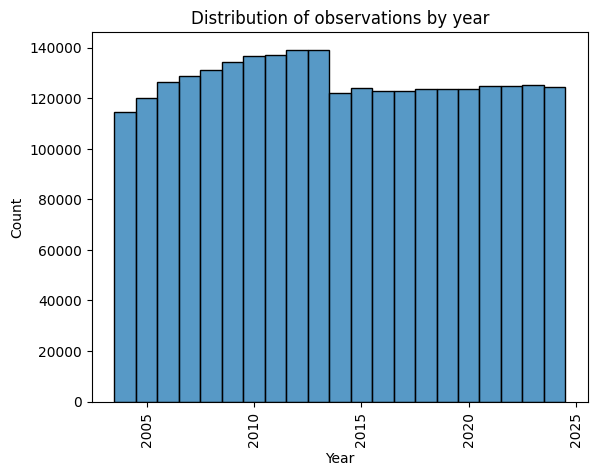

In [29]:
# Distribution of observations over years
sns.histplot(data = df_house, x = 'year', discrete = True)
plt.title('Distribution of observations by year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

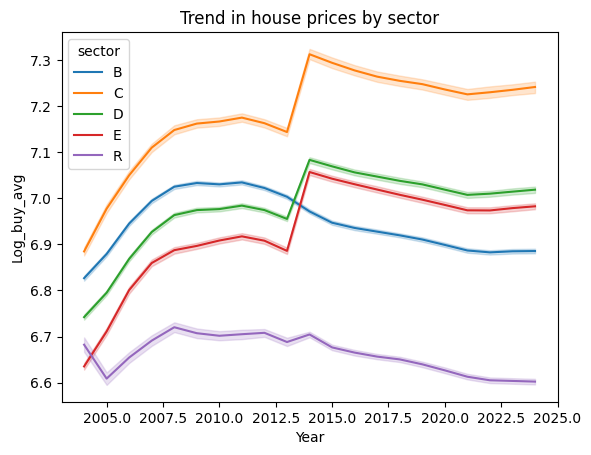

In [30]:
sns.lineplot(data = df_house, x = 'year', y = 'log_buy_avg', hue = 'sector')
plt.title('Trend in house prices by sector')
plt.xlabel('Year')
plt.ylabel('Log_buy_avg')
plt.show()

Due to the changes in collection and manipulation methods between 2013_2 and 2014_1, prices trends are affected. 
The analysis will be conducted over the period 2014 - 2024. Lease_min and max values will be filtered out. Istat codes are updated.

In [31]:
# Create dataset for post 2014 analysis
df_post_2014 = df_house[df_house['year'] >= 2014].copy()

In [32]:
df_post_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1361099 entries, 3654507 to 7201293
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   mun_istat      1361099 non-null  object  
 1   mun_key        1361099 non-null  object  
 2   mun_name_norm  1361099 non-null  object  
 3   mun_name       1361099 non-null  object  
 4   year           1361099 non-null  int64   
 5   year_semester  1361099 non-null  object  
 6   semester       1361099 non-null  int64   
 7   region         1361099 non-null  category
 8   prov           1361099 non-null  object  
 9   sector         1361099 non-null  category
 10  zone           1361099 non-null  object  
 11  type           1361099 non-null  object  
 12  condition      1361099 non-null  category
 13  buy_min        1361099 non-null  float64 
 14  buy_max        1361099 non-null  float64 
 15  log_buy_min    1361099 non-null  float64 
 16  log_buy_max    1361099 non-null  fl

Save the dataset

In [33]:
df_post_2014.to_parquet('datasets/house_post_2014.parquet', index = False)